# Heart Failure Prediction - IA01 Project Autumn 2025
# UTT - Introduction to Artificial Intelligence
 
This notebook contains the exploratory data analysis, data preprocessing, 
and machine learning modeling steps for predicting heart failure. 
The dataset used combines multiple sources including Cleveland, Hungarian, 
Switzerland, Long Beach VA, and Stalog datasets, resulting in 918 observations 
after removing duplicates.

The goal is to analyze the dataset, identify important features, 
train several classification models (kNN, Decision Tree, Random Forest, 
Logistic Regression, Neural Networks), and evaluate their performance.


# We import important libraries to analyze the dataset
 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# EDA

In [5]:
heart_data = pd.read_csv('../data/heart.csv')
print(f"In our dataset we have {heart_data.shape[0]} rows and {heart_data.shape[1]} columns")
print(heart_data.head())

In our dataset we have 918 rows and 12 columns
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [6]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### We can see that we have some anomalies:
  - Cholesterol (min=0, max=603)
  - RestingBP (min=0, max=200)
  - Oldpeak (min=-2.6)
  - MaxHR (min=60)

### RestingBP

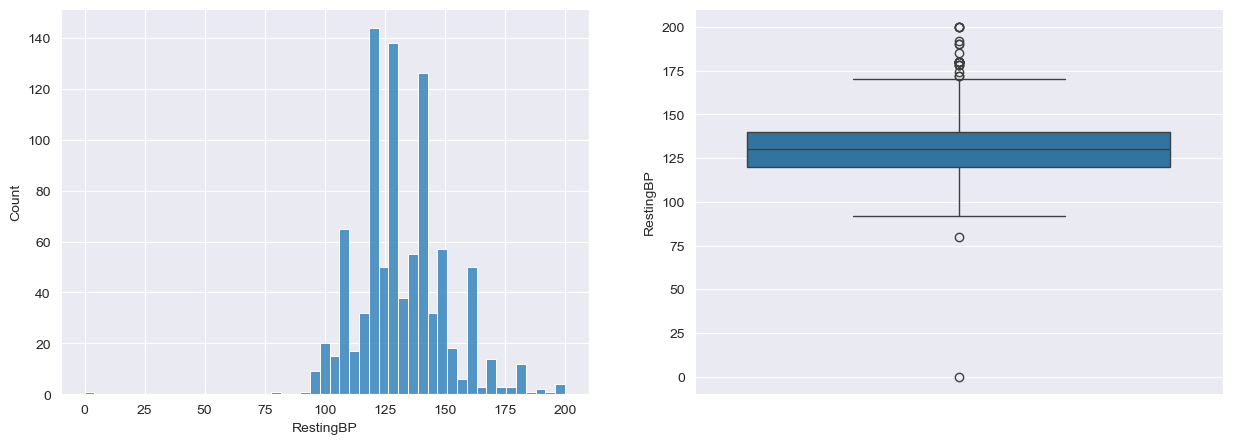

In [8]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='RestingBP', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='RestingBP', data=heart_data)
plt.show()

In [9]:
Q1 = heart_data['RestingBP'].quantile(0.25)
Q3 = heart_data['RestingBP'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
heart_data[ (heart_data['RestingBP'] < lower) | (heart_data['RestingBP'] > upper) ]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0
123,58,F,ATA,180,393,0,Normal,110,Y,1.0,Flat,1
189,53,M,ASY,180,285,0,ST,120,Y,1.5,Flat,1
190,46,M,ASY,180,280,0,ST,120,N,0.0,Up,0
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
274,45,F,ATA,180,295,0,Normal,180,N,0.0,Up,0
275,59,M,NAP,180,213,0,Normal,100,N,0.0,Up,0
278,57,F,ASY,180,347,0,ST,126,Y,0.8,Flat,0
314,53,M,ASY,80,0,0,Normal,141,Y,2.0,Down,0
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1


In [10]:
heart_data['RestingBP'] = heart_data['RestingBP'].replace(0, np.nan)
median_bp = heart_data['RestingBP'].median()
heart_data['RestingBP'] = heart_data['RestingBP'].fillna(median_bp)

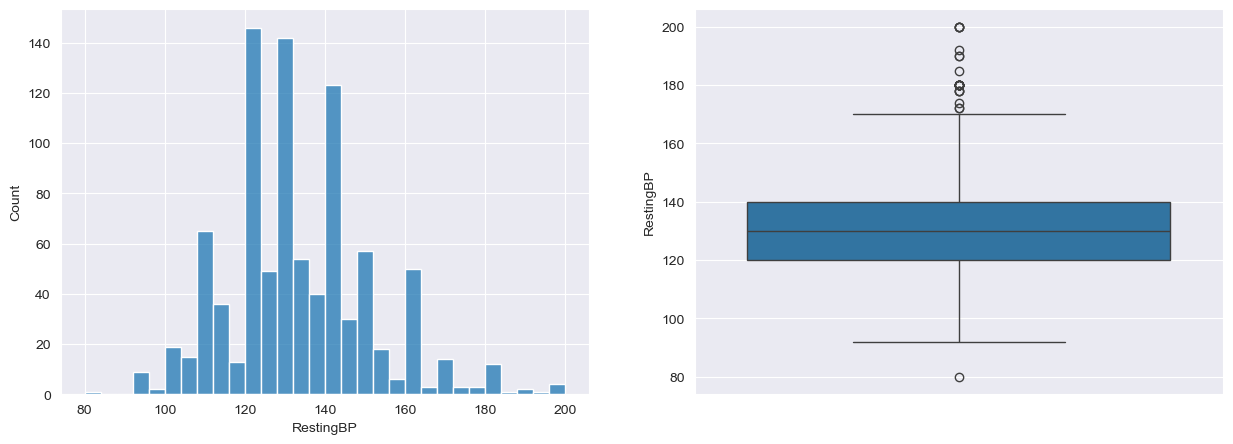

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='RestingBP', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='RestingBP', data=heart_data)
plt.show()

#### Summary:
   - Replace an obvious anomalie 0 to median
   - Everything else is left like it is even though the values are extreme (but real)

### Cholesterol

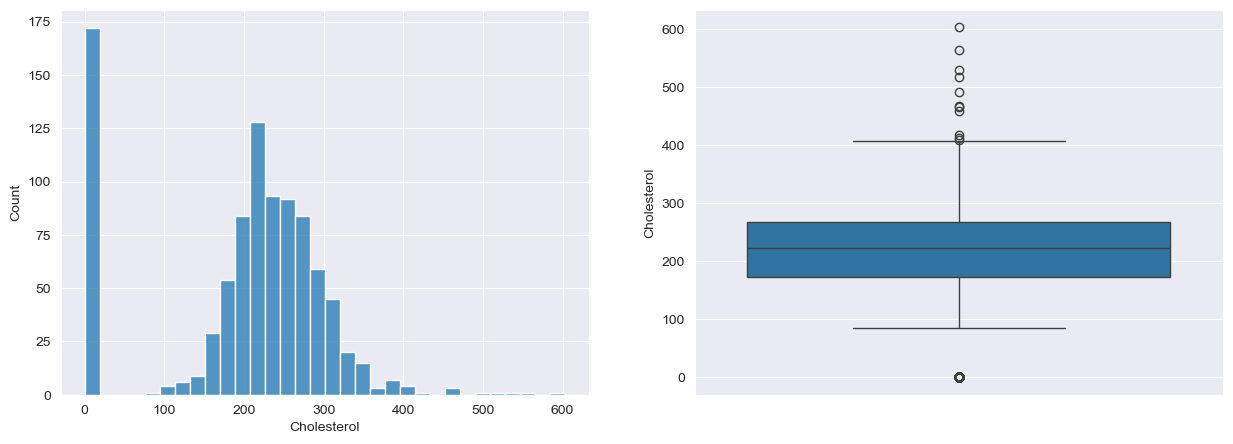

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='Cholesterol', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='Cholesterol', data=heart_data)
plt.show()

In [13]:
heart_data["Cholesterol"] = heart_data["Cholesterol"].replace(0, np.nan)
median_cholesterol = heart_data["Cholesterol"].median()
heart_data["Cholesterol"] = heart_data["Cholesterol"].fillna(median_cholesterol)

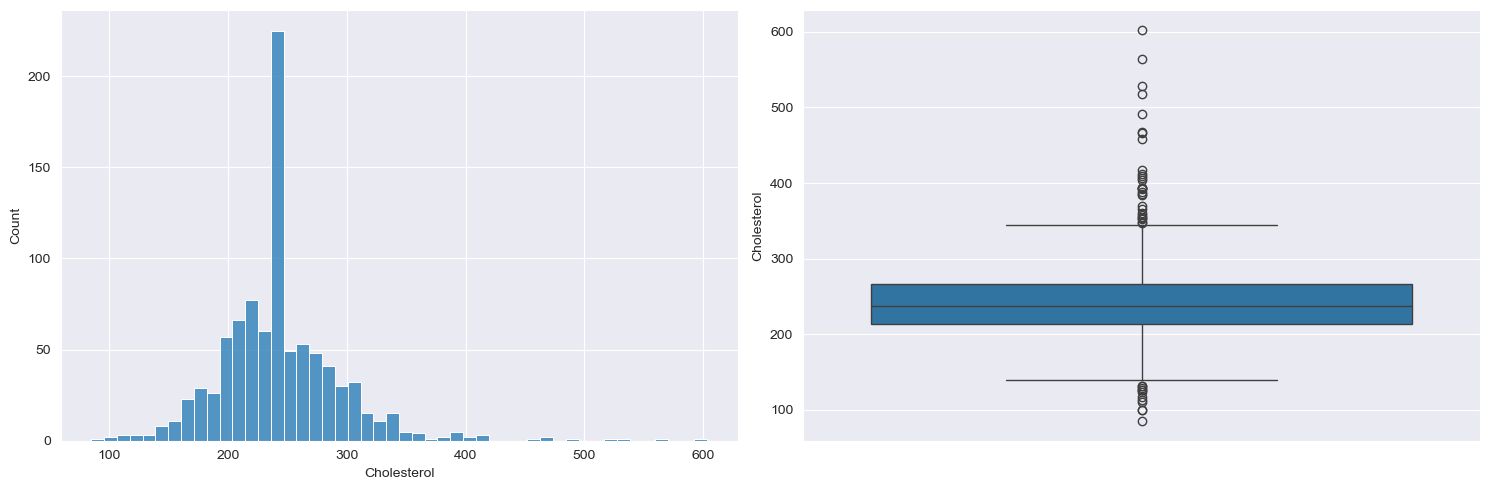

In [14]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='Cholesterol', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='Cholesterol', data=heart_data)
plt.tight_layout()
plt.show()

#### Summary
   - Replace an obvious anomalie 0 to median
   - Everything else is left like it is even though the values are extreme (but real)

### Oldpeak

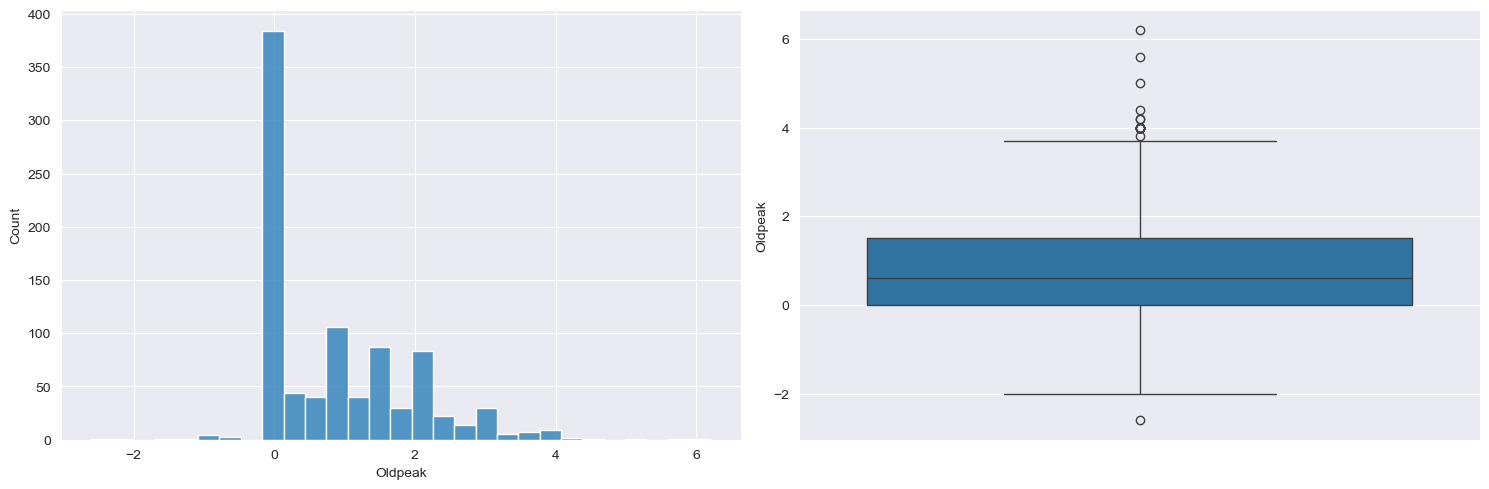

In [15]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='Oldpeak', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='Oldpeak', data=heart_data)
plt.tight_layout()
plt.show()


In [16]:
Q1 = heart_data['Oldpeak'].quantile(0.25)
Q3 = heart_data['Oldpeak'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
heart_data[ (heart_data['Oldpeak'] < lower) | (heart_data['Oldpeak'] > upper) ]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
68,52,M,ASY,160.0,246.0,0,ST,82,Y,4.0,Flat,1
166,50,M,ASY,140.0,231.0,0,ST,140,Y,5.0,Flat,1
324,46,M,ASY,100.0,237.0,1,ST,133,N,-2.6,Flat,1
500,65,M,ASY,136.0,248.0,0,Normal,140,Y,4.0,Down,1
521,61,M,ASY,120.0,282.0,0,ST,135,Y,4.0,Down,1
537,74,M,ASY,150.0,258.0,1,ST,130,Y,4.0,Down,1
559,64,M,ASY,134.0,273.0,0,Normal,102,Y,4.0,Down,1
624,63,F,ASY,150.0,407.0,0,LVH,154,N,4.0,Flat,1
702,59,M,TA,178.0,270.0,0,LVH,145,N,4.2,Down,0
732,56,F,ASY,200.0,288.0,1,LVH,133,Y,4.0,Down,1


#### Analysis of `Oldpeak`

This feature is one of the most critical, and also one of the most complex.

1.  **Initial Statistical Look:** A `describe()` shows a `min` of **-2.6** and a `max` of **6.2**, with a median of 0.6.
2.  **Domain Knowledge Check:** Unlike `RestingBP` or `Cholesterol`, these extreme values are **not errors**.
    * `Oldpeak` measures the ST segment depression induced by exercise relative to rest.
    * **Positive values (`> 0`):** This indicates **ST Depression**. High values (like `4.0`, `6.2`) are a classic sign of severe ischemia (lack of blood flow). These are critical data points.
    * **Negative values (`< 0`):** This indicates **ST Elevation**. This is a rare but **extremely severe** clinical sign. It can point to an acute infarction (heart attack) or coronary artery spasm.

#### 🎯 Conclusion

The `Oldpeak` column contains **no impossible values** or "trash" data.

The negative values (`-2.6`, `-1.5`, etc.) and the high positive values (`6.2`, `5.0`, etc.) are arguably the **most important data points** in the dataset, representing the most severe cases.

**Decision:** This feature **will not be cleaned or altered**. It is ready for analysis as-is.

### MaxHR

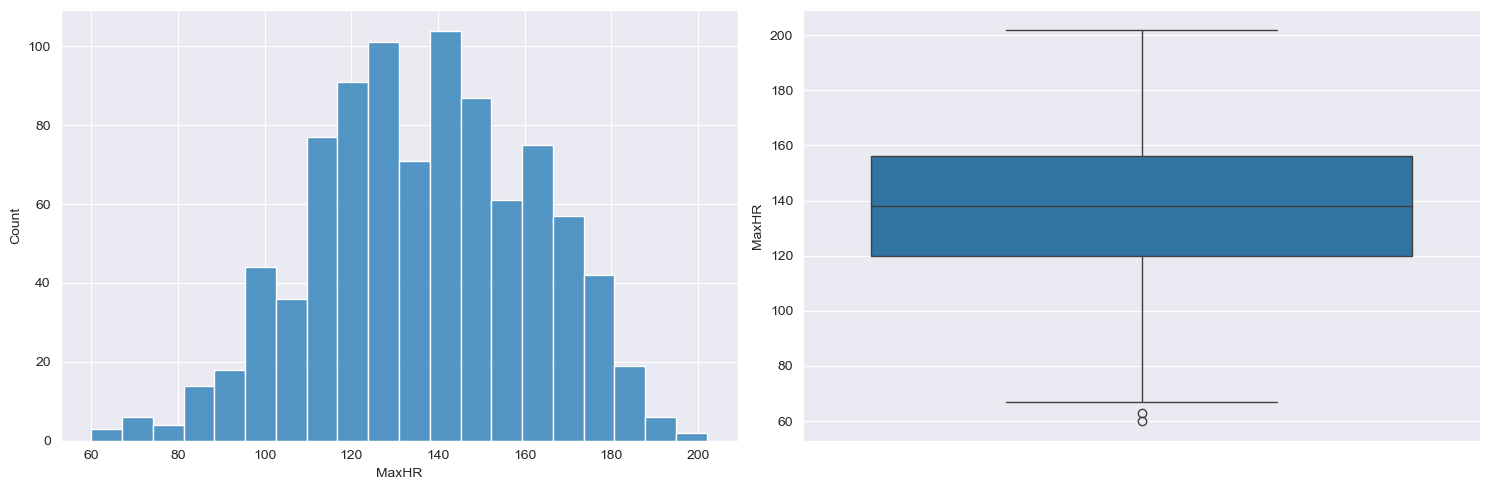

In [18]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.histplot(x='MaxHR', data=heart_data)
plt.subplot(1,2,2)
sns.boxplot(y='MaxHR', data=heart_data)
plt.tight_layout()
plt.show()

In [19]:
Q1 = heart_data['MaxHR'].quantile(0.25)
Q3 = heart_data['MaxHR'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
heart_data[ (heart_data['MaxHR'] < lower) | (heart_data['MaxHR'] > upper) ]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
370,60,M,ASY,135.0,237.0,0,Normal,63,Y,0.5,Up,1
390,51,M,ASY,140.0,237.0,0,Normal,60,N,0.0,Flat,1


#### Analysis of `MaxHR` (Maximum Heart Rate)

1.  **Statistical Look:** The data for `MaxHR` appears clean and robust. The `mean` (136.8) and `median` (138.0) are very close, indicating a symmetric, "bell-shaped" distribution with no significant skew from anomalies (unlike `Cholesterol`).
2.  **IQR Analysis:** An IQR analysis identified two statistical outliers on the low end: **60** and **63**.
3.  **Domain Knowledge Check:** These values are **not errors**. A `MaxHR` of 60 is physically possible, though extremely low for a stress test.
    * **Clinical Meaning:** This doesn't represent a data error (like `RestingBP = 0`), but rather a critical clinical finding. It likely signifies that the patient had extremely low exercise tolerance and the test was stopped immediately.
    * **Correlation:** A look at these two rows shows they both have `heartDisease = 1`. This suggests that an inability to raise one's heart rate during the test is a strong predictor of heart disease.

#### 🎯 Conclusion

The low `MaxHR` values are not "trash" but "treasure." They are valid, clinically significant data points.

**Decision:** This feature **will not be cleaned or altered**. It is ready for analysis as-is.